In this notebook, we will be working through the micrograd [video](https://www.youtube.com/watch?v=VMj-3S1tku0) by the GOAT Andrej Karpathy. Goal is to not simply copy paste code, but to type each character by hand and wrangle everything to build an intuitive understanding.

Derivatives are the mathematical foundation of how neural networks learn. When we train a neural network, we're trying to find the set of weights that minimise some loss function — a single number that measures how wrong our model is. The way we reduce that loss is by computing the derivative of the loss with respect to every weight in the network. That derivative tells us which direction to nudge each weight to make the loss go down. Do that repeatedly and the network learns. The algorithm that computes all those derivatives efficiently is called **backpropagation**, and micrograd will build it from scratch.


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Section 1: What is a derivate? Building intuition.


## Simple function


In [3]:
# start with a simple sample function

def f(x):
    return 3*x**2 - 4*x + 5

f(3.0)

20.0

xs: [-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]
ys: [100.      91.6875  83.75    76.1875  69.      62.1875  55.75    49.6875
  44.      38.6875  33.75    29.1875  25.      21.1875  17.75    14.6875
  12.       9.6875   7.75     6.1875   5.       4.1875   3.75     3.6875
   4.       4.6875   5.75     7.1875   9.      11.1875  13.75    16.6875
  20.      23.6875  27.75    32.1875  37.      42.1875  47.75    53.6875]


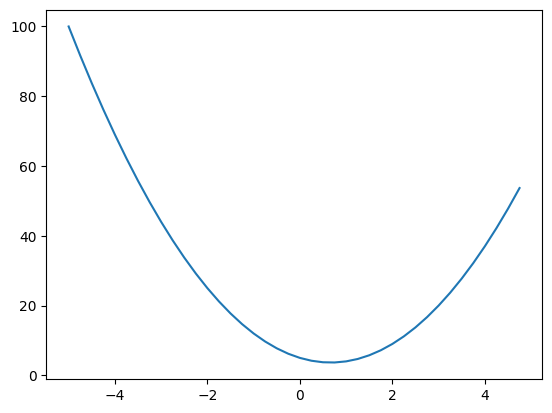

In [4]:
# let us draw the function
xs = np.arange(-5, 5, 0.25) # let a bunch of points from -5 (inc) to 5 (not inc) at a step size of 0.25
print(f"xs: {xs}")

ys = f(xs)
print(f"ys: {ys}")

# plot it
plt.plot(xs, ys)

The function we defined above was a parabola. Now lets think about what is a derivative? A derivative represents the instantaneous rate of change of a function with respect to its variable. In layman terms it tells us how does the output (y in our case) vary when we make a very small (infinitesimally) change (h) in our input (x).  
This is how its defined mathematically -

$$
f'(x) = \lim_{h \to 0} \frac{f(x + h) - f(x)}{h}
$$

In practice we approximate this by choosing a very small but finite h. The choice of h is a balancing act: too large and the approximation is inaccurate (the definition assumes h→0), too small and floating point precision breaks down (computers can't represent arbitrarily small differences exactly, so the numerator becomes 0). A value around 1e-5 is typically a reliable sweet spot.


In [ ]:
# now lets understand this with an example
h = 0.000001
x = 3.0 # when our input is at 3.0 and we slightly nudge it higher, by what
# sensitity does the output y change

In [9]:
f(x+h) # looking at our parabola this should be higher than f(3) which was 20


20.000014000003002

In [ ]:
f(x+h) - f(x) # change in y when we nudge x by h at x=3

1.4000003002223593e-05

In [14]:
(f(x+h) - f(x))/h # at what rate does y change (or how sensitive is it) when we nudge h slightly higher at x=3. this is the derivate.

14.000003002223593

This derivate turns out to be 14, which matches the derivate of f(x). From calculas we know derivate of function

$$
f = 3x^2 - 4x + 5
$$

is

$$
f' = 6x - 4
$$

and f'(3) = 6\*3 - 4 = 14


In [18]:
# lets create a simple helper to calculate derivate at a point using the limit formula

def derivate(func, x):
    h = 0.00001
    return (func(x+h) - func(x)) / h

derivate(f, 3) # note that in python we can pass functions as arguments like so

14.00003000000538

Just to bring home the point, even visually looking at the parabola, we can see that when x=-3, nudging x higher by a small amount h will decrease y, thus we expect the derivate at -3 to negative


In [17]:
derivate(f, -3)

-21.999970000052823

## Visualising the derivative as a tangent line

Geometrically, the derivative at a point is the slope of the line that just touches the curve there — the **tangent line**. This is the clearest way to see what the derivative actually means.


In [29]:
xs = np.arange(-5, 5, 0.25)

# note: we compute slope inline here because the variable name 'derivate' was
# reused as a float in the partial derivatives cells above, shadowing the function
def slope_at(func, x, h=1e-5):
    return (func(x + h) - func(x)) / h

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, x0, color in zip(axes, [3.0, -3.0], ['tab:orange', 'tab:green']):
    slope = slope_at(f, x0)
    tangent = lambda x, x0=x0, slope=slope: f(x0) + slope * (x - x0)

    ax.plot(xs, f(xs), label='f(x)', color='tab:blue')
    ax.plot(xs, tangent(xs), '--', label=f'tangent at x={x0} (slope={slope:.1f})', color=color)
    ax.scatter([x0], [f(x0)], color='red', zorder=5)
    ax.set_ylim(-20, 100)
    ax.legend()
    ax.set_title(f'Derivative at x={x0}')
    ax.grid(True)

plt.tight_layout()
plt.show()
# At x=3: positive slope (14) — moving right increases f(x)
# At x=-3: negative slope (-22) — moving right decreases f(x)

## Slightly more complex function


In [20]:
a = 2.0
b = -3.0
c = 10.0

d = a*b + c

print(d)

4.0


Now lets think through the derivates of d wrt the inputs a, b, and c.

lets start with 'a'


In [ ]:
h = 0.00001

a = 2.0
b = -3.0
c = 10.0

d = a*b + c
d_change = (a+h)*b + c
derivate = (d_change - d) / h

print(f"original d: {d}")
print(f"New d on nudging a: {d_change}") # this will be lower than d since we are increasing a while b is negative, this pushing d down
print(f"Derivate: {derivate}")

original d: 4.0
New d on nudging a: 3.9999699999999994
Derivate: -3.000000000064062


This tells us that at this point in the function, when we nudge a, the value of d goes down and the slope/rate of that is -3. This matches what calculas tells us.

$$
\frac{\partial d}{\partial a} = b
$$

$$
\frac{\partial d}{\partial b} = a
$$

$$
\frac{\partial d}{\partial c} = 1
$$


In [ ]:
# how does 'b' influence the output 'd'

h = 0.00001

a = 2.0
b = -3.0
c = 10.0

d = a*b + c
d_change = a*(b+h) + c
derivate = (d_change - d) / h

print(f"original d: {d}")
print(f"New d on nudging b: {d_change}")
print(f"Derivate: {derivate}")  # should be equal to a from the formula above

original d: 4.0
New d on nudging b: 4.00002
Derivate: 2.0000000000131024


In [ ]:
# how does 'c' influence the output 'd'

h = 0.0000001

a = 2.0
b = -3.0
c = 10.0

d = a*b + c
d_change = a*b + (c + h)
derivate = (d_change - d) / h

print(f"original d: {d}")
print(f"New d on nudging c: {d_change}")
print(f"Derivate: {derivate}") # should be equal to 1

original d: 4.0
New d on nudging c: 4.000000099999999
Derivate: 0.999999993922529


## The Gradient

When a function has multiple inputs, its derivative with respect to each input is called a **partial derivative** (written ∂ instead of d, to signal "this is one of several"). We just computed three of them: ∂d/∂a, ∂d/∂b, ∂d/∂c.

Collect all the partial derivatives into a single vector and you have the **gradient**:

$$
\nabla d = \left[\frac{\partial d}{\partial a},\ \frac{\partial d}{\partial b},\ \frac{\partial d}{\partial c}\right] = [b,\ a,\ 1] = [-3,\ 2,\ 1]
$$

### Why does the gradient point towards steepest increase?

Each partial derivative tells us: "if I nudge this one input up by a tiny amount, how much does the output change?" A large positive value means that input has a big upward pull on the output. A large negative value means it pulls the output down.

The gradient vector packages all of those individual sensitivities together. When you move in the direction the gradient points — increasing each input proportionally to its partial derivative — every input is working in concert to push the output up as hard as possible. Any other direction would have at least one input "fighting" the others, producing less total increase.

A concrete way to see this: imagine standing on a hilly landscape and taking one step of fixed length in any direction. The direction that gains you the most height is exactly where the ground is rising fastest under your feet — the gradient direction. Step perpendicular to the gradient and you stay at the same height (that is a **level curve**). Step against the gradient and you descend.

For our example, the gradient is [-3, 2, 1]. This tells us:

- Increasing `a` _decreases_ d (slope = -3, the steepest puller)
- Increasing `b` _increases_ d (slope = 2)
- Increasing `c` _increases_ d (slope = 1, weakest effect)

So to increase d as fast as possible, decrease `a` and increase `b` and `c` — proportional to [-3, 2, 1].

To minimise the function (i.e. reduce the loss in a neural network) we move in the **opposite** direction — this is exactly what gradient descent does:

$$
\text{weight} \leftarrow \text{weight} - \text{learning rate} \times \frac{\partial \text{loss}}{\partial \text{weight}}
$$

Every weight in a neural network is like `a`, `b`, or `c` here. Backpropagation is the algorithm that efficiently computes all those partial derivatives at once, by working backwards through the computation graph. That is what micrograd will implement.


# Section 2: Building Micrograd

This section will cover building the micrograd engine for automatic differentiation — i.e. automatically calculating the derivative of a function w.r.t ALL of its parameters.

In Section 1 we computed derivatives by hand using the limit formula, nudging each input by a small h and observing the change. That works fine for simple expressions, but a real neural network has millions of parameters. Computing derivatives one at a time, manually, is completely infeasible.

**Automatic differentiation (autograd)** solves this. Instead of computing derivatives analytically or numerically, we build a system that:

1. Records every mathematical operation as it happens (building a computation graph)
2. Walks backwards through that graph, applying the chain rule at each step to efficiently compute the derivative of the output with respect to every single input — all at once

PyTorch's `torch.Tensor` does exactly this under the hood. Micrograd is a from-scratch, minimal version of the same idea — small enough to understand completely, but identical in spirit to what powers modern deep learning.


## Section 2.1 - The Value Class

The key challenge with automatic differentiation is that Python's built-in numeric types (floats, ints) just compute values — they have no memory of how they got there. If you write `d = a * b + c`, Python evaluates that to a single float and throws away all information about `a`, `b`, and `c`.

To backpropagate, we need to remember the full history of the computation: what operations were performed, and what inputs were involved at each step. That history forms a **Directed Acyclic Graph (DAG)** — a graph where each node is a value, and each edge points from an input to the output it helped create. "Acyclic" means no cycles — an output can't also be its own input, which would make the computation undefined.

We build a custom `Value` class to wrap each number so we can attach this extra bookkeeping to it. Every time two `Value` objects interact (via addition, multiplication, etc.), the result is a new `Value` that remembers its parents and the operation that created it. Once we have the full graph, we can traverse it backwards from the output to compute gradients everywhere.


In [ ]:
# lets start by defining a very simple value class

class Value:

    def __init__(self, data):
        self.data = data

a = Value(2.0)
a

In [ ]:
# lets add a fn to pretty print the value class as opposed to the gibberish above
# python allows overriding the __repr__ fn for this

class Value:

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"

a = Value(2.0)
a

Value(data=2.0)

In [38]:
# now we can see that at least we get a nice print output. Lets try adding two values
a = Value(2.0)
b = Value(-3.0)

a + b

TypeError: unsupported operand type(s) for +: 'Value' and 'Value'

In [ ]:
# this does not work because we havent told python how to add two 'Value' objects.
# we can define that by overloading the __add__ fn

class Value:

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        _sum = self.data + other.data
        return Value(_sum)

a = Value(2.0)
b = Value(-3.0)

c = a + b
c

Value(data=-1.0)

In [42]:
# what if we want to add integer?
a = Value(2.0)
a + 2

AttributeError: 'int' object has no attribute 'data'

In [ ]:
# that does not work because so far we were expecting addition to occur on two Value objects
# let us fix that

class Value:

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # create a Value object from other if it isnt
        _sum = self.data + other.data
        return Value(_sum)

a = Value(2.0)
a + 2

Value(data=4.0)

In [46]:
# while a + 2 works, 2 + a doesnt because for a + 2 python will internally call a.__add__(2) which we just supported
# however, when we do 2 + a, python will call 2.__add__(a), which is callig the add from the int object which does now know to add Value object
# in python, the way to fix that is by overloading the __radd__ fn
2 + a

TypeError: unsupported operand type(s) for +: 'int' and 'Value'

In [ ]:
# lets overlaod __radd__

class Value:

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # create a Value object from other if it isnt
        _sum = self.data + other.data
        return Value(_sum)

    def __radd__(self, other):
        # we simply switch the other around since __add__ already handles adding int to Value
        return self + other # equivalent to self.__add__(other)

a = Value(2.0)
print(a + 2)
print(2 + a)

Value(data=4.0)
Value(data=4.0)


In [ ]:
# lets add similar fn for multiply now so we can recreate the d = a*b + c expression from section 1

class Value:

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # create a Value object from other if it isnt
        _sum = self.data + other.data
        return Value(_sum)

    def __radd__(self, other):
        # we simply switch the other around since __add__ already handles adding int to Value
        return self + other # equivalent to self.__add__(other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) # create a Value object from other if it isnt
        _product = self.data * other.data
        return Value(_product)

    def __rmul__(self, other):
        # we simply switch the other around since __mul__ already handles adding int to Value
        return self * other # equivalent to self.__mul__(other)

a = Value(2.0)
print(a + 2)
print(2 + a)
print(a*3)
print(3*a)

Value(data=4.0)
Value(data=4.0)
Value(data=6.0)
Value(data=6.0)


In [50]:
# Lets recreate our example now using Value object

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a*b + c
d

Value(data=4.0)

In [55]:
# now, when we ask for derivates or gradients, we ask how does changing a change d.
# we can imagine an expression or a fn as a DAG, in our case the node 'd' will have
# pointers coming to it from 'a', 'b' and 'c'.

# so we need to know what values depend on other values. We can keep track of this using
# a children tuple

class Value:

    def __init__(self, data, _children=()):
        self.data = data
        self._prev = set(_children) # keep track of all objects which created this one

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # create a Value object from other if it isnt
        _sum = self.data + other.data
        return Value(_sum, _children = (self, other)) # add the children, here _sum was created by adding self and other

    def __radd__(self, other):
        # we simply switch the other around since __add__ already handles adding int to Value
        return self + other # equivalent to self.__add__(other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) # create a Value object from other if it isnt
        _product = self.data * other.data
        return Value(_product, (self, other))  # add the children, here _product was created by adding self and other

    def __rmul__(self, other):
        # we simply switch the other around since __mul__ already handles adding int to Value
        return self * other # equivalent to self.__mul__(other)

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a*b + c
d, d._prev

(Value(data=4.0), {Value(data=-6.0), Value(data=10.0)})

By tracking `_prev` (the children that created each node), we've built a **computation graph**. For the expression `d = a*b + c`, it looks like this:

```
a ──┐
    ├──[*]── (a*b) ──┐
b ──┘                ├──[+]── d
c ───────────────────┘
```

Each node knows which operation created it and which nodes fed into it. This is exactly the structure we need for backpropagation: to compute how `d` changes with respect to `a`, we just follow the edges backwards from `d` through `+`, then through `*`, applying the chain rule at each step.

This is why PyTorch builds a computation graph every time you do forward pass operations on tensors — it's recording the history it needs for `.backward()`.


In [ ]:
# now we know what children created this value, but we also need to keep track of what operation created this value
# we need to keep track of the operation because gradients/derivates flowing through different operations are different
# for .e.g da/dd turned out to be 'b' while da/dc turned out to be '1'.

class Value:

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children) # keep track of all objects which created this one
        self._op = _op

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # create a Value object from other if it isnt
        _sum = self.data + other.data
        return Value(_sum, (self, other), "+") # added the op

    def __radd__(self, other):
        # we simply switch the other around since __add__ already handles adding int to Value
        return self + other # equivalent to self.__add__(other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) # create a Value object from other if it isnt
        _product = self.data * other.data
        return Value(_product, (self, other), '*')  # added the op

    def __rmul__(self, other):
        # we simply switch the other around since __mul__ already handles adding int to Value
        return self * other # equivalent to self.__mul__(other)

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a*b + c
d, d._prev, d._op

(Value(data=4.0), {Value(data=-6.0), Value(data=10.0)}, '+')

Knowing the operation (`_op`) that created each node is essential because **different operations have different gradient rules**.

Recall from Section 1:

- For `d = a*b + c`, the partial derivative `∂d/∂a = b` (came from the multiply)
- The partial derivative `∂d/∂c = 1` (came from the add)

When we walk backwards through the graph, at each node we need to know: "what operation created me, so I can apply the right gradient formula?" The chain rule says the gradient at each input equals the gradient flowing in from the output, multiplied by the local gradient of this operation. That local gradient formula is different for `*`, `+`, `tanh`, `exp`, etc.

So `_op` tells the backward pass _which formula to use_ at each node. Without it, we'd have the graph structure but no way to know how to propagate gradients through it.


In [ ]:
# We add a label field so each node can carry a human-readable name (e.g. 'a', 'b', 'L').
# It defaults to '' so existing code that doesn't pass a label still works fine.
# The label is purely for visualisation — it has no effect on the math.

class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children) # keep track of all objects which created this one
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # create a Value object from other if it isnt
        _sum = self.data + other.data
        return Value(_sum, (self, other), "+") # added the op

    def __radd__(self, other):
        # we simply switch the other around since __add__ already handles adding int to Value
        return self + other # equivalent to self.__add__(other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) # create a Value object from other if it isnt
        _product = self.data * other.data
        return Value(_product, (self, other), '*')  # added the op

    def __rmul__(self, other):
        # we simply switch the other around since __mul__ already handles adding int to Value
        return self * other # equivalent to self.__mul__(other)

In [78]:
from graphviz import Digraph

def trace(root):
    # DFS (depth-first search) to collect every node and edge in the graph.
    # Starting from the root (output node), we recursively visit each node's
    # _prev children, building up the full set of nodes and directed edges.
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))  # edge goes from child -> parent (input -> output)
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        # Each Value gets a rectangular 'record' node showing its label and data value.
        dot.node(name=str(id(n)), label = "{%s | data %.4f}" % (n.label, n.data), shape='record')
        if n._op:
            # If this node was produced by an operation, we create a small extra node
            # just for the op symbol (e.g. '+', '*'). This makes the graph easier to read
            # by showing the operation explicitly, rather than cramming it inside the value node.
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))  # op node -> value node

    for n1, n2 in edges:
        # Connect input nodes to the op node of their output (not directly to the output value node),
        # so the graph reads: input -> op -> output
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

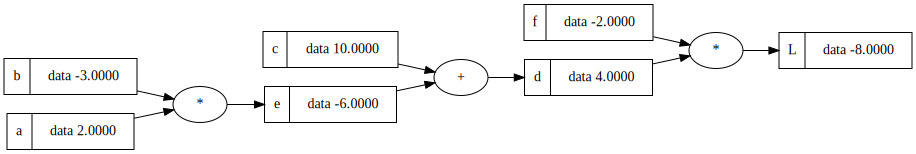

In [80]:
# Lets also make our expression more complicated.
# Think of this as a tiny neural network:
#   a, b  -> inputs being combined by a weight-like multiplication
#   c     -> a bias term being added
#   f     -> another weight applied to the result
#   L     -> the final output (think: loss)
# This mirrors exactly what happens inside a neuron: inputs * weights + bias,
# then passed through more operations to produce a scalar loss.

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

# d = a*b + c, instead of doing this directly, lets first create a variable for a*b so that d operates on atomic units
e = a*b
e.label = 'e'

d = e + c
d.label = 'd'

f = Value(-2.0, label='f')

L = f * d
L.label = 'L'

draw_dot(L)

Now this effectively constitutes a **forward pass** — we take in inputs (`a`, `b`, `c`, `f`), feed them through the expression graph, and produce a single scalar output `L`.

In a real neural network, this is identical to what happens when you run data through the network: each layer transforms the activations through learned weights and biases until you arrive at a final output, and then a loss function turns that output into a single number measuring how wrong the network was. That number is `L`.

The computation graph we just drew captures _every_ operation that contributed to `L`. This is the structure that makes backpropagation possible — we know exactly which path each input took to reach the output, so we can work backwards to figure out how much each input contributed to the final value.


## Section 2.2: Manual Backward Pass

In the forward pass we computed `L` from the inputs. Now we run the **backward pass**: computing the derivative of `L` with respect to every node in the graph — i.e. how much does `L` change if we nudge each intermediate value or input by a tiny amount.

This is backpropagation. The key mathematical tool is the **chain rule**: if `L` depends on `d`, and `d` depends on `a`, then:

$$
\frac{\partial L}{\partial a} = \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial a}
$$

We start at the output (`L`) where the gradient is trivially 1 (L changes at rate 1 with respect to itself), then propagate backwards through each operation, multiplying local gradients as we go. We'll do this manually first so the mechanics are completely clear before automating it.

In our example, we can assume `L` to represent the loss (obtained through a cost function), whie the inputs (`a`, `b`, `c`, `f`) are representing the **weights** of the neural network. With the goal of minimizing the loss, we want to calculate the gradients of the loss w.r.t to the weights. We know gradient points to the direction of maximum ascent, so if we do down instead, i.e. reverse the sign the do descent, then that should nudge the weights in the direction of minimizing the loss.


In [ ]:
# now we need to add a variable to our Value class in order to sotre the gradient. If we know the current
# gradient, the children who made the current node, and the operation which made the current node, then we
# can use the chain rule to propragate the gradients back into the children (and so on) using the chain rule.

class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0 # add a default gradient of 0

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        _sum = self.data + other.data
        return Value(_sum, (self, other), "+")

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        _product = self.data * other.data
        return Value(_product, (self, other), '*')

    def __rmul__(self, other):
        return self * other

# let us also update the graph drawing to show the gradient

from graphviz import Digraph

def trace(root):
    # DFS (depth-first search) to collect every node and edge in the graph.
    # Starting from the root (output node), we recursively visit each node's
    # _prev children, building up the full set of nodes and directed edges.
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))  # edge goes from child -> parent (input -> output)
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        # Each Value gets a rectangular 'record' node showing its label and data value.
        dot.node(name=str(id(n)), label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # If this node was produced by an operation, we create a small extra node
            # just for the op symbol (e.g. '+', '*'). This makes the graph easier to read
            # by showing the operation explicitly, rather than cramming it inside the value node.
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))  # op node -> value node

    for n1, n2 in edges:
        # Connect input nodes to the op node of their output (not directly to the output value node),
        # so the graph reads: input -> op -> output
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

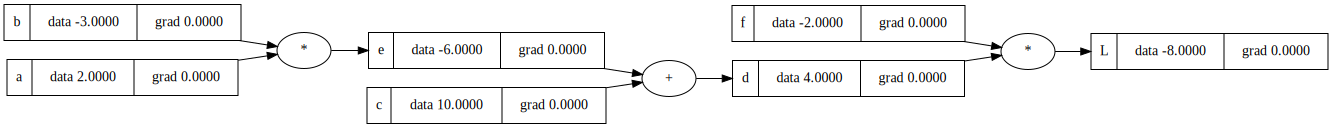

In [85]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b
e.label = 'e'

d = e + c
d.label = 'd'

f = Value(-2.0, label='f')

L = f * d
L.label = 'L'

draw_dot(L)

Initial gradient is now 0 everywhere. Now we can manually do the backpropagation to fill the grad at every node for `L`. (i.e. gradient of `L` w.r.t that node.). We start from the last node, i.e the output which is `L`


1. calculating
   $$
   \frac{\partial L}{\partial L} = 1
   $$
   derivate of a variable w.r.t itself is simply 1. That was easy :)


In [86]:
L.grad = 1.0 # base case

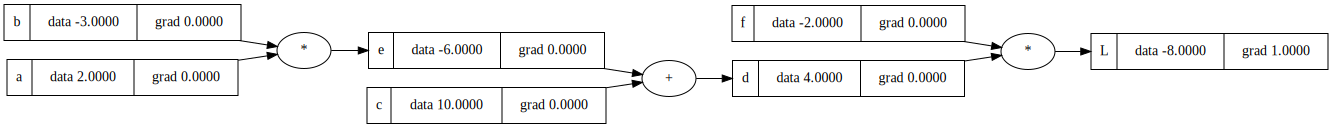

In [87]:
draw_dot(L)

Now we want to calculate derivate of `L` w.r.t `f` and `d`. we know `L = d * f`

Now from calculas, we know that when `L = d * f`, then

$$
 \frac{\partial L}{\partial d} = f
$$

and

$$
 \frac{\partial L}{\partial d} = d
$$


Just this once, lets also derive this to see if it makes sense.

$$
\frac{\partial L}{\partial d} = \lim_{h \to 0} \frac{L(d + h, f) - L(d, f)}{h}
$$

$$
     = \lim_{h \to 0} \frac{(d+h)*f - d*f}{h}
$$

$$
        = \lim_{h \to 0} \frac{d*f + f*h - d*f}{h}
$$

$$
     = \lim_{h \to 0} \frac{f*h}{h}
$$

$$
     = \lim_{h \to 0} f
$$

$$
     = f
$$

Thus we can confirm our above derivate formula was correct.

Thus,

$$
 \frac{\partial L}{\partial d} = f,    \frac{\partial L}{\partial d} = d
$$


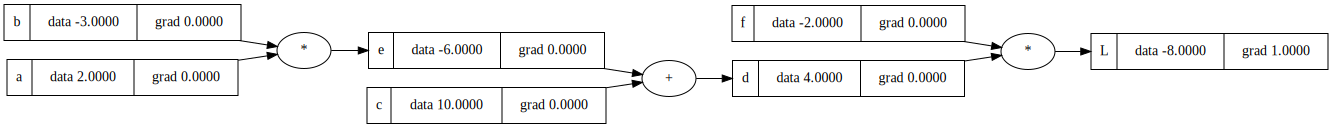

In [88]:
draw_dot(L)

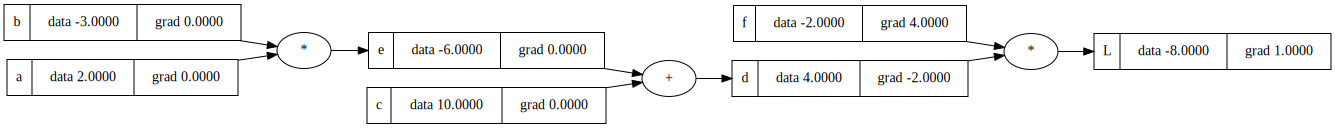

In [89]:
# thus,
f.grad = 4.0
d.grad = -2

draw_dot(L)

In [121]:
def confirm_derivate(nudge_label):
    # we can also confirm the derivate above by the limit formula and calculating a numerical
    # gradient with a small step size 'h'
    h = 0.00001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b
    d = e + c
    f = Value(-2.0, label='f')
    L1 = f * d

    a = Value(2.0, label='a')
    if nudge_label == 'a':
        a.data += h
    b = Value(-3.0, label='b')
    if nudge_label == 'b':
        b.data += h
    c = Value(10.0, label='c')
    if nudge_label == 'c':
        c.data += h
    e = a*b
    if nudge_label == 'e':
        e.data += h
    d = e + c
    if nudge_label == 'd':
        d.data += h
    f = Value(-2.0, label='f')
    if nudge_label == 'f':
        f.data += h
    L2 = f * d

    grad = (L2.data - L1.data)/h
    return grad

In [122]:
# this matches what we set above

print(confirm_derivate(nudge_label='f'))
print(confirm_derivate(nudge_label='d'))


4.000000000026205
-1.9999999999242843


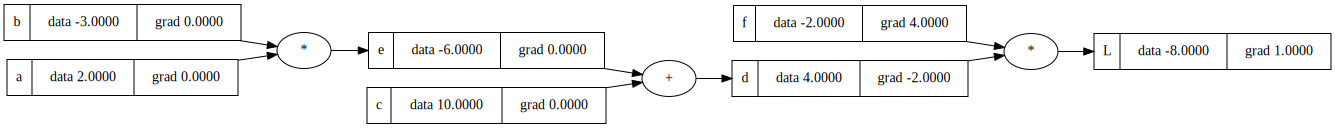

In [105]:
# thus we now have gradients for L, f and d. Continuing on
draw_dot(L)

The above was relatively trivial. Now if we understand how the gradient flows from `d` back to `c` and `e`, then we essentially know the ENTIRE backprogation. This node is thus very important to understand.

Let's think through calculating the derivative of `L` w.r.t `c` which will show us how sensitive `L` is to changes in `c`, i.e. we want to calculate `∂L/∂c`.

Here is what we know:

1. We know gradient of `L` w.r.t `d` ie. `∂L/∂d`
2. We know how `d` was made, i.e. `d = e + c`

I mentioned chain rule above. Using this chain rule, what we can say is that

$$
\frac{\partial L}{\partial c} = \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial c}
$$

We already know `∂L/∂d`, and from calculas we know that when `d = c + e` then `∂d/∂c` = 1

Thus,

`∂L/∂c` = `∂L/∂d` _ 1 = -2.0 _ 1 = -2.0


In [123]:
print(confirm_derivate(nudge_label='c'))


-1.9999999999242843


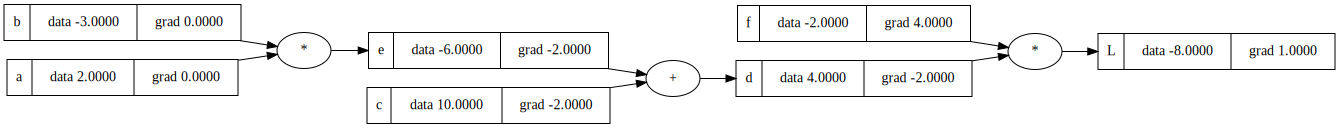

In [111]:
# by symmetry it will be the same for e
# thus,

e.grad = d.grad * 1.0
c.grad = d.grad * 1.0

draw_dot(L)

Now to calculate gradients for `b` and `a` we can again apply the chain rule.

$$
\frac{\partial L}{\partial a} = \frac{\partial L}{\partial e} \cdot \frac{\partial e}{\partial a}
$$

We already know `∂L/∂e`, and from calculas we know that when `e = a * b` then `∂e/∂a = b`

Thus,

`∂L/∂a` = `∂L/∂e * b` = -2 \* -3 = -6.0


In [124]:
print(confirm_derivate(nudge_label='a'))
print(confirm_derivate(nudge_label='b'))



6.000000000128124
-4.000000000026205


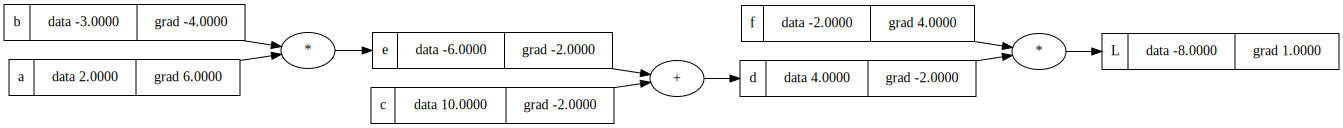

In [114]:
# by symmetry, calulation for b grad will be similar
a.grad = e.grad * b.data
b.grad = e.grad * a.data

# THUS NOW WE HAVE MANUALLY CALCULATED ALL THE DERIVATIVES
draw_dot(L)

In [126]:
for node in ['a', 'b', 'c', 'd', 'e', 'f']:
    print(f"Derivate of L w.r.t {node} is = {confirm_derivate(node)}")

Derivate of L w.r.t a is = 6.000000000128124
Derivate of L w.r.t b is = -4.000000000026205
Derivate of L w.r.t c is = -1.9999999999242843
Derivate of L w.r.t d is = -1.9999999999242843
Derivate of L w.r.t e is = -1.9999999999242843
Derivate of L w.r.t f is = 4.000000000026205


Thus we have now manually backprogagated the signal manuall all the way from L back to all the other nodes!!!
